In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.layers.core import Activation, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K


from keras.layers import Layer
%matplotlib inline

In [2]:
train_images_src = 'DIPLOMA/Dataset_for_train/images/'
train_masks_src = 'DIPLOMA/Dataset_for_train/masks/'

test_images_src = 'DIPLOMA/Dataset_for_test/images/'
test_masks_src = 'DIPLOMA/Dataset_for_test/masks/'

In [3]:
def read_images_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

def read_masks_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path, 0)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

train_images = read_images_to_array(train_images_src)
train_masks = read_masks_to_array(train_masks_src)

test_images = read_images_to_array(test_images_src)
test_masks = read_masks_to_array(test_masks_src)

In [4]:
len(train_images), len(train_masks), len(test_images), len(test_masks)

(4577, 4577, 309, 309)

In [5]:
train_images[0].shape, train_masks[0].shape, test_images[0].shape, test_masks[0].shape

((256, 256, 3), (256, 256), (256, 256, 3), (256, 256))

In [6]:
# Нормализуем
x = train_images/255
y = train_masks/255

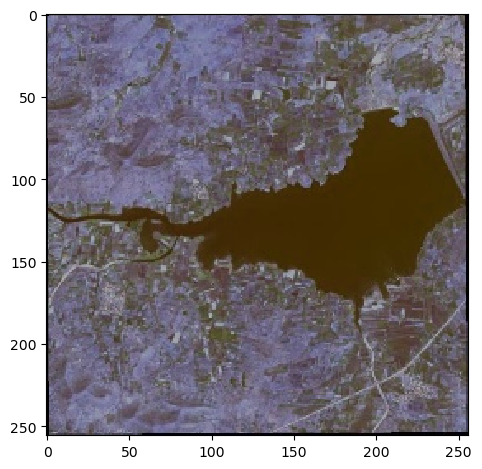

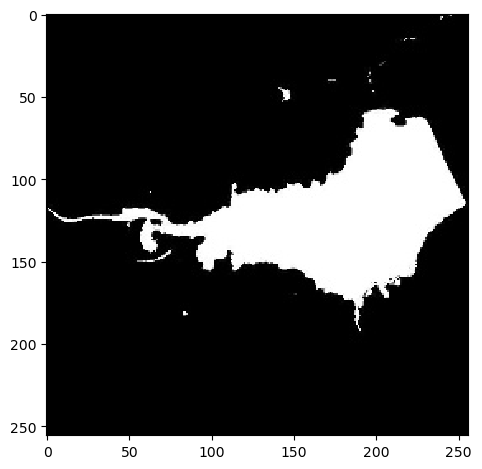

In [7]:
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show() 

test_img = x[random_num]
test_img2 = y[random_num]

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
def segnet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    # Output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv6)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [10]:
def get_model():
    return segnet((256,256,3), 2)

In [11]:
model = get_model()
#model.summary()

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=10, 
          epochs=30,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/30
367/367 [==============================] - 100s 252ms/step - loss: 0.3887 - accuracy: 0.6339 - val_loss: 0.3548 - val_accuracy: 0.6507
Epoch 2/30
367/367 [==============================] - 87s 237ms/step - loss: 0.2920 - accuracy: 0.6668 - val_loss: 0.2767 - val_accuracy: 0.6714
Epoch 3/30
367/367 [==============================] - 87s 237ms/step - loss: 0.2762 - accuracy: 0.6723 - val_loss: 0.2914 - val_accuracy: 0.6736
Epoch 4/30
367/367 [==============================] - 87s 238ms/step - loss: 0.2679 - accuracy: 0.6742 - val_loss: 0.2578 - val_accuracy: 0.6900
Epoch 5/30
367/367 [==============================] - 87s 238ms/step - loss: 0.2570 - accuracy: 0.6790 - val_loss: 0.2512 - val_accuracy: 0.6917
Epoch 6/30
367/367 [==============================] - 87s 236ms/step - loss: 0.2506 - accuracy: 0.6804 - val_loss: 0.3064 - val_accuracy: 0.6774
Epoch 7/30
367/367 [==============================] - 87s 238ms/step - loss: 0.2472 - accuracy: 0.6826 - val_loss: 0.2508 - val_a

In [ ]:
model.save("segnet_256_auged.h5")